In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import EfficientNet_V2_S_Weights
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

Class distribution:
Class 1: 1920 samples (25.00%)
Class 2: 1920 samples (25.00%)
Class 3: 1536 samples (20.00%)
Class 4: 1152 samples (15.00%)
Class 5: 768 samples (10.00%)
Class 6: 384 samples (5.00%)

Imbalance ratio: 5.00


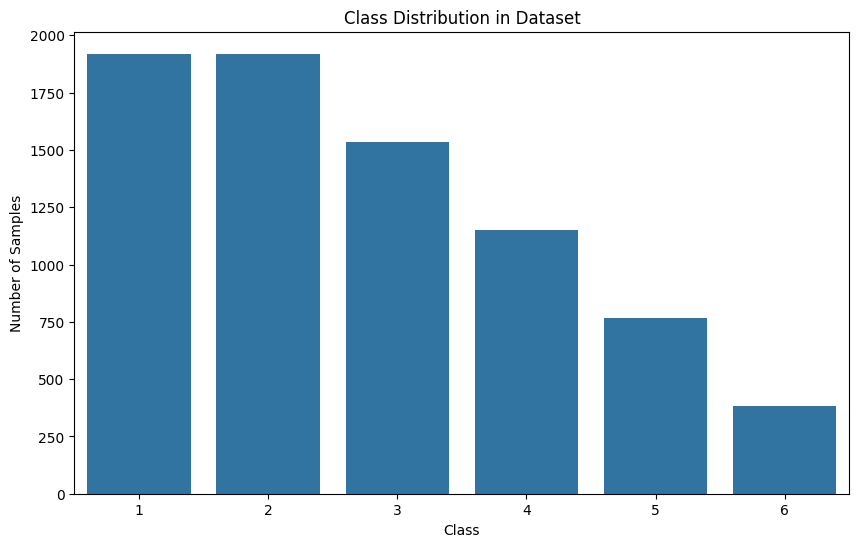

In [9]:
def check_dataset_balance(csv_file, label_column):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each class
    class_counts = df[label_column].value_counts().sort_index()
    
    # Calculate the percentage of each class
    class_percentages = 100 * class_counts / len(df)
    
    # Print the counts and percentages
    print("Class distribution:")
    for class_label, count in class_counts.items():
        percentage = class_percentages[class_label]
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")
    
    # Calculate the imbalance ratio
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
    
    # Visualize the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Usage example
check_dataset_balance('./COMP90086_2024_Project_train/train.csv', 'stable_height')

In [10]:
class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, augment=False):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.stability_data) * (2 if self.augment else 1)

    def __getitem__(self, idx):
        original_idx = idx // 2 if self.augment else idx
        flip = self.augment and idx % 2 == 1

        img_name = str(self.stability_data.iloc[original_idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        stability_height = self.stability_data.iloc[original_idx, -1]
        stability_class = int(stability_height) - 1

        if flip:
            image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(stability_class, dtype=torch.long)

class StabilityPredictor(nn.Module):
    def __init__(self, num_classes=6):
        super(StabilityPredictor, self).__init__()
        weights = EfficientNet_V2_S_Weights.DEFAULT
        self.efficientnet = models.efficientnet_v2_s(weights=weights)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [1]:
def calculate_dataset_stats(csv_file, img_dir):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    dataset = StabilityDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print("Calculating dataset statistics...")
    for i, images in enumerate(loader):
        for j in range(3):
            mean[j] += images[:, j, :, :].mean()
            std[j] += images[:, j, :, :].std()
        if (i+1) % 1000 == 0:
            print(f"Processed {i+1} images")
    
    mean.div_(len(dataset))
    std.div_(len(dataset))
    
    return mean, std

# Calculate stats
csv_file = './COMP90086_2024_Project_train/train.csv'
img_dir = './COMP90086_2024_Project_train/train'
mean, std = calculate_dataset_stats(csv_file, img_dir)

print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

# Save the stats
torch.save({'mean': mean, 'std': std}, 'dataset_stats.pth')
print("Dataset statistics saved to 'dataset_stats.pth'")

Calculating dataset statistics...
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Dataset mean: tensor([0.4677, 0.4412, 0.4065])
Dataset std: tensor([0.2721, 0.2285, 0.1913])
Dataset statistics saved to 'dataset_stats.pth'


In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_training=True)
        
        # Validation phase
        model.eval()
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer, device, is_training=False)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            model.load_state_dict(best_model)
            break

    return model

def run_epoch(model, data_loader, criterion, optimizer, device, is_training=True):
    running_loss = 0.0
    correct = 0
    total = 0

    # Create progress bar
    progress_bar = tqdm(data_loader, desc="Training" if is_training else "Validating")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        if is_training:
            optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        if is_training:
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# Load pre-calculated dataset statistics
stats = torch.load('dataset_stats.pth')
mean, std = stats['mean'], stats['std']
print(f"Loaded dataset mean: {mean}")
print(f"Loaded dataset std: {std}")

# Create transform with loaded normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# Create full dataset with augmentation and correct normalization
full_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', 
                                img_dir='./COMP90086_2024_Project_train/train', 
                                transform=transform,
                                augment=True)  # Enable augmentation

# Split dataset into train and validation
val_ratio = 0.025
dataset_size = len(full_dataset)
val_size = int(val_ratio * dataset_size)
train_size = dataset_size - val_size
print(f'Splitting dataset into {(1 - val_ratio)}:{val_ratio} training/test split')
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)

model = StabilityPredictor(num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

print('Training...')
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

torch.save(model.state_dict(), 'stability_predictor_efficientnetv2_classification_augmented.pth')

Loaded dataset mean: tensor([0.4677, 0.4412, 0.4065])
Loaded dataset std: tensor([0.2721, 0.2285, 0.1913])
Splitting dataset into 0.975:0.025 training/test split
Training...
Epoch 1/30


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.21it/s, loss=1.0824, acc=53.65%]


Train Loss: 1.3781, Train Acc: 40.87%
Val Loss: 1.1304, Val Acc: 53.65%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/30


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s, loss=1.1128, acc=56.77%]


Train Loss: 1.1010, Train Acc: 55.44%
Val Loss: 1.0502, Val Acc: 56.77%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 3/30


Training:  60%|█████▉    | 280/468 [00:34<00:23,  8.15it/s, loss=1.0431, acc=61.28%]


KeyboardInterrupt: 

In [7]:
import csv

def predict(model, test_loader, device):
    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for inputs, ids in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy() + 1)  # Add 1 to convert back to 1-6 range
            image_ids.extend(ids.numpy())  # Convert tensor to numpy array

    return predictions, image_ids

def main():
    # Set up device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the unlabeled dataset
    test_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_test/test.csv', 
                                    img_dir='./COMP90086_2024_Project_test/test', 
                                    transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load the trained model
    model = StabilityPredictor(num_classes=6)
    model.load_state_dict(torch.load('stability_predictor_efficientnetv2_classification_augmented.pth'))
    model.to(device)

    # Make predictions
    predictions, image_ids = predict(model, test_loader, device)

    # Save predictions to CSV
    with open('predictions.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'labels'])
        for img_id, pred in zip(image_ids, predictions):
            writer.writerow([int(img_id) + 1, int(pred)])  # Ensure both are integers

    print("Predictions saved to predictions.csv")

if __name__ == '__main__':
    main()

Predictions saved to predictions.csv


Loaded dataset mean: tensor([0.4677, 0.4412, 0.4065])
Loaded dataset std: tensor([0.2721, 0.2285, 0.1913])


KeyError: 'image_id'

In [27]:
class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, augment=False):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment

        # Create mappings for categorical variables
        self.shapeset_map = {s: i for i, s in enumerate(self.stability_data['shapeset'].unique())}
        self.type_map = {t: i for i, t in enumerate(self.stability_data['type'].unique())}
        self.instability_type_map = {it: i for i, it in enumerate(self.stability_data['instability_type'].unique())}

    def __len__(self):
        return len(self.stability_data) * (2 if self.augment else 1)

    def __getitem__(self, idx):
        original_idx = idx // 2 if self.augment else idx
        flip = self.augment and idx % 2 == 1

        img_name = str(self.stability_data.iloc[original_idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        row = self.stability_data.iloc[original_idx]
        stability_class = int(row['total_height']) - 1

        # Get additional features
        shapeset = self.shapeset_map[row['shapeset']]
        type_ = self.type_map[row['type']]
        instability_type = self.instability_type_map[row['instability_type']]
        cam_angle = row['cam_angle']

        if flip:
            image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(stability_class, dtype=torch.long), torch.tensor([shapeset, type_, instability_type, cam_angle], dtype=torch.float)

class MultiTaskStabilityPredictor(nn.Module):
    def __init__(self, num_stability_classes=6, num_shapeset_classes=None, num_type_classes=None, num_instability_type_classes=None):
        super(MultiTaskStabilityPredictor, self).__init__()
        weights = EfficientNet_V2_S_Weights.DEFAULT
        self.efficientnet = models.efficientnet_v2_s(weights=weights)
        num_ftrs = self.efficientnet.classifier[1].in_features
        
        # Remove the original classifier
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-1])
        
        # Add new classifiers for each task
        self.stability_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_stability_classes)
        )
        self.shapeset_classifier = nn.Linear(num_ftrs, num_shapeset_classes)
        self.type_classifier = nn.Linear(num_ftrs, num_type_classes)
        self.instability_type_classifier = nn.Linear(num_ftrs, num_instability_type_classes)
        self.cam_angle_regressor = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        features = self.efficientnet(x)
        features = features.view(features.size(0), -1)
        
        stability = self.stability_classifier(features)
        shapeset = self.shapeset_classifier(features)
        type_ = self.type_classifier(features)
        instability_type = self.instability_type_classifier(features)
        cam_angle = self.cam_angle_regressor(features)
        
        return stability, shapeset, type_, instability_type, cam_angle

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torchvision import transforms, models
from torchvision.models import EfficientNet_V2_S_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm



def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_training=True)
        
        # Validation phase
        model.eval()
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer, device, is_training=False)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            model.load_state_dict(best_model)
            break

    return model

def run_epoch(model, data_loader, criterion, optimizer, device, is_training=True):
    running_loss = 0.0
    correct = 0
    total = 0

    # Create progress bar
    progress_bar = tqdm(data_loader, desc="Training" if is_training else "Validating")

    for inputs, stability_labels, aux_labels in progress_bar:
        inputs, stability_labels, aux_labels = inputs.to(device), stability_labels.to(device), aux_labels.to(device)
        
        if is_training:
            optimizer.zero_grad()
        
        stability, shapeset, type_, instability_type, cam_angle = model(inputs)
        
        # Calculate losses for each task
        stability_loss = criterion['stability'](stability, stability_labels)
        shapeset_loss = criterion['shapeset'](shapeset, aux_labels[:, 0].long())
        type_loss = criterion['type'](type_, aux_labels[:, 1].long())
        instability_type_loss = criterion['instability_type'](instability_type, aux_labels[:, 2].long())
        cam_angle_loss = criterion['cam_angle'](cam_angle.squeeze(), aux_labels[:, 3])
        
        # Combine losses
        loss = stability_loss + 0.2 * (shapeset_loss + type_loss + instability_type_loss + cam_angle_loss)
        
        if is_training:
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = stability.max(1)
        total += stability_labels.size(0)
        correct += predicted.eq(stability_labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def main():
    # Load pre-calculated dataset statistics
    stats = torch.load('dataset_stats.pth')
    mean, std = stats['mean'], stats['std']
    print(f"Loaded dataset mean: {mean}")
    print(f"Loaded dataset std: {std}")

    # Create transform with loaded normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
    ])

    # Create full dataset with augmentation and correct normalization
    full_dataset = StabilityDataset(
        csv_file='./COMP90086_2024_Project_train/train.csv', 
        img_dir='./COMP90086_2024_Project_train/train', 
        transform=transform,
        augment=True
    )

    # Split dataset into train and validation
    dataset_size = len(full_dataset)
    val_ratio = 0.05
    print(f'Splitting into {(1-val_ratio)} : {val_ratio} test/train split')
    val_size = int(val_ratio * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    model = MultiTaskStabilityPredictor(
        num_stability_classes=6, 
        num_shapeset_classes=len(full_dataset.shapeset_map),
        num_type_classes=len(full_dataset.type_map),
        num_instability_type_classes=len(full_dataset.instability_type_map)
    )
    
    criterion = {
        'stability': nn.CrossEntropyLoss(),
        'shapeset': nn.CrossEntropyLoss(),
        'type': nn.CrossEntropyLoss(),
        'instability_type': nn.CrossEntropyLoss(),
        'cam_angle': nn.MSELoss()
    }
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=3)

    torch.save(model.state_dict(), 'multitask_stability_predictor.pth')

if __name__ == "__main__":
    main()

Loaded dataset mean: tensor([0.4677, 0.4412, 0.4065])
Loaded dataset std: tensor([0.2721, 0.2285, 0.1913])
Epoch 1/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 17.28it/s, loss=0.6160, acc=90.04%]


Train Loss: 0.8008, Train Acc: 80.91%
Val Loss: 0.5171, Val Acc: 90.04%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 18.15it/s, loss=0.3278, acc=94.60%]


Train Loss: 0.4681, Train Acc: 92.17%
Val Loss: 0.3745, Val Acc: 94.60%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 3/30


Validating: 100%|██████████| 48/48 [00:03<00:00, 14.12it/s, loss=0.3821, acc=95.51%]


Train Loss: 0.3795, Train Acc: 94.70%
Val Loss: 0.3447, Val Acc: 95.51%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 4/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 17.05it/s, loss=0.3305, acc=95.38%]


Train Loss: 0.3240, Train Acc: 96.35%
Val Loss: 0.3286, Val Acc: 95.38%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 5/30


Validating: 100%|██████████| 48/48 [00:03<00:00, 15.81it/s, loss=0.3189, acc=95.77%]


Train Loss: 0.3044, Train Acc: 96.75%
Val Loss: 0.3224, Val Acc: 95.77%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 6/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 17.13it/s, loss=0.3119, acc=94.86%]


Train Loss: 0.2959, Train Acc: 96.95%
Val Loss: 0.3782, Val Acc: 94.86%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 7/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 17.33it/s, loss=0.2596, acc=94.27%]


Train Loss: 0.2693, Train Acc: 97.30%
Val Loss: 0.4154, Val Acc: 94.27%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 8/30


Validating: 100%|██████████| 48/48 [00:03<00:00, 15.06it/s, loss=0.2831, acc=96.42%]


Train Loss: 0.2620, Train Acc: 97.64%
Val Loss: 0.2956, Val Acc: 96.42%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 9/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 18.46it/s, loss=0.2442, acc=97.33%]


Train Loss: 0.2346, Train Acc: 98.28%
Val Loss: 0.2753, Val Acc: 97.33%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 10/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 18.56it/s, loss=0.2457, acc=97.20%]


Train Loss: 0.2112, Train Acc: 98.71%
Val Loss: 0.2782, Val Acc: 97.20%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 11/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 18.74it/s, loss=0.2964, acc=97.01%]


Train Loss: 0.2275, Train Acc: 98.19%
Val Loss: 0.2756, Val Acc: 97.01%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 12/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 18.67it/s, loss=0.1948, acc=97.66%]


Train Loss: 0.2023, Train Acc: 98.66%
Val Loss: 0.2702, Val Acc: 97.66%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 13/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 17.07it/s, loss=0.3098, acc=95.83%]


Train Loss: 0.1980, Train Acc: 98.81%
Val Loss: 0.3051, Val Acc: 95.83%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 14/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 19.12it/s, loss=0.2450, acc=96.42%]


Train Loss: 0.2008, Train Acc: 98.53%
Val Loss: 0.3169, Val Acc: 96.42%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 15/30


Validating: 100%|██████████| 48/48 [00:02<00:00, 18.78it/s, loss=0.2224, acc=97.27%]


Train Loss: 0.1803, Train Acc: 98.92%
Val Loss: 0.2726, Val Acc: 97.27%
Learning Rate: 0.001000
------------------------------------------------------------
Early stopping triggered after 15 epochs


In [35]:
class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.test_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, idx):
        img_name = str(self.test_data.iloc[idx, 0])  # Assuming the image ID is in the first column
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, img_name

def predict_test_set(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, img_names in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(device)
            stability, _, _, _, _ = model(inputs)
            _, predicted = stability.max(1)
            
            for img_name, pred in zip(img_names, predicted):
                predictions.append((img_name, pred.item() + 1))  # Add 1 to convert back to 1-6 range

    return predictions

def save_predictions_to_csv(predictions, output_file):
    df = pd.DataFrame(predictions, columns=['id', 'stable_height'])
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

def predict_and_save():
    # Load the trained model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Create a temporary dataset to get the number of classes
    temp_dataset = StabilityDataset(
        csv_file='./COMP90086_2024_Project_train/train.csv',
        img_dir='./COMP90086_2024_Project_train/train',
        transform=None,
        augment=False
    )
    
    model = MultiTaskStabilityPredictor(
        num_stability_classes=6, 
        num_shapeset_classes=len(temp_dataset.shapeset_map),
        num_type_classes=len(temp_dataset.type_map),
        num_instability_type_classes=len(temp_dataset.instability_type_map)
    )
    model.load_state_dict(torch.load('multitask_stability_predictor.pth'))
    model.to(device)

    # Load pre-calculated dataset statistics
    stats = torch.load('dataset_stats.pth')
    mean, std = stats['mean'], stats['std']

    # Create transform for test set
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
    ])

    # Create test dataset and dataloader
    test_dataset = TestDataset(
        csv_file='./COMP90086_2024_Project_test/test.csv',
        img_dir='./COMP90086_2024_Project_test/test',
        transform=test_transform
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Predict on test set
    predictions = predict_test_set(model, test_loader, device)

    # Save predictions to CSV
    save_predictions_to_csv(predictions, 'test_predictions.csv')


predict_and_save()


Predicting: 100%|██████████| 60/60 [00:02<00:00, 23.35it/s]

Predictions saved to test_predictions.csv
